In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from matplotlib.text import Text
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs out of one DataFrame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(168528, 109)


In [4]:

# Get all time groups and an action timeline of each patient and compute the engagement delta
actions_list = ['INJURY_RECORD', 'PATIENT_RECORD', 'S_A_L_T_WALK_IF_CAN', 'S_A_L_T_WAVE_IF_CAN', 'S_A_L_T_WAVED']
rows_list = []
for (session_uuid, time_group), df1 in nu.get_session_groupby(
	mask_series=None, extra_column='time_group'
):
	
    # Get all patients in that period
    for patient_id, df2 in df1.groupby('patient_id'):
        row_dict = {}
        row_dict['session_uuid'] = session_uuid
        row_dict['time_group'] = time_group
        row_dict['patient_id'] = patient_id
        
        # Get the timeline for patient engagement
        mask_series = df2.action_type.isin(actions_list)
        xmin = df2[~mask_series].elapsed_time.min(); row_dict['engagement_start'] = xmin
        xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
        engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta

        # Get a sequence of elapsed times for patient engagements
        times_list = [xmin]
        mask_series = df2.action_type.isin(['PATIENT_ENGAGED'])
        times_list += df2[mask_series].sort_values('elapsed_time').elapsed_time.tolist()

        # Ccompute their differences
        deltas_list = []
        for i in range(len(times_list) - 1):
            deltas_list.append(times_list[i + 1] - times_list[i])

        # Add these in separate columns
        for i, delta in enumerate(deltas_list):
            row_dict[f'delta{i:02d}'] = delta
        
        rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)

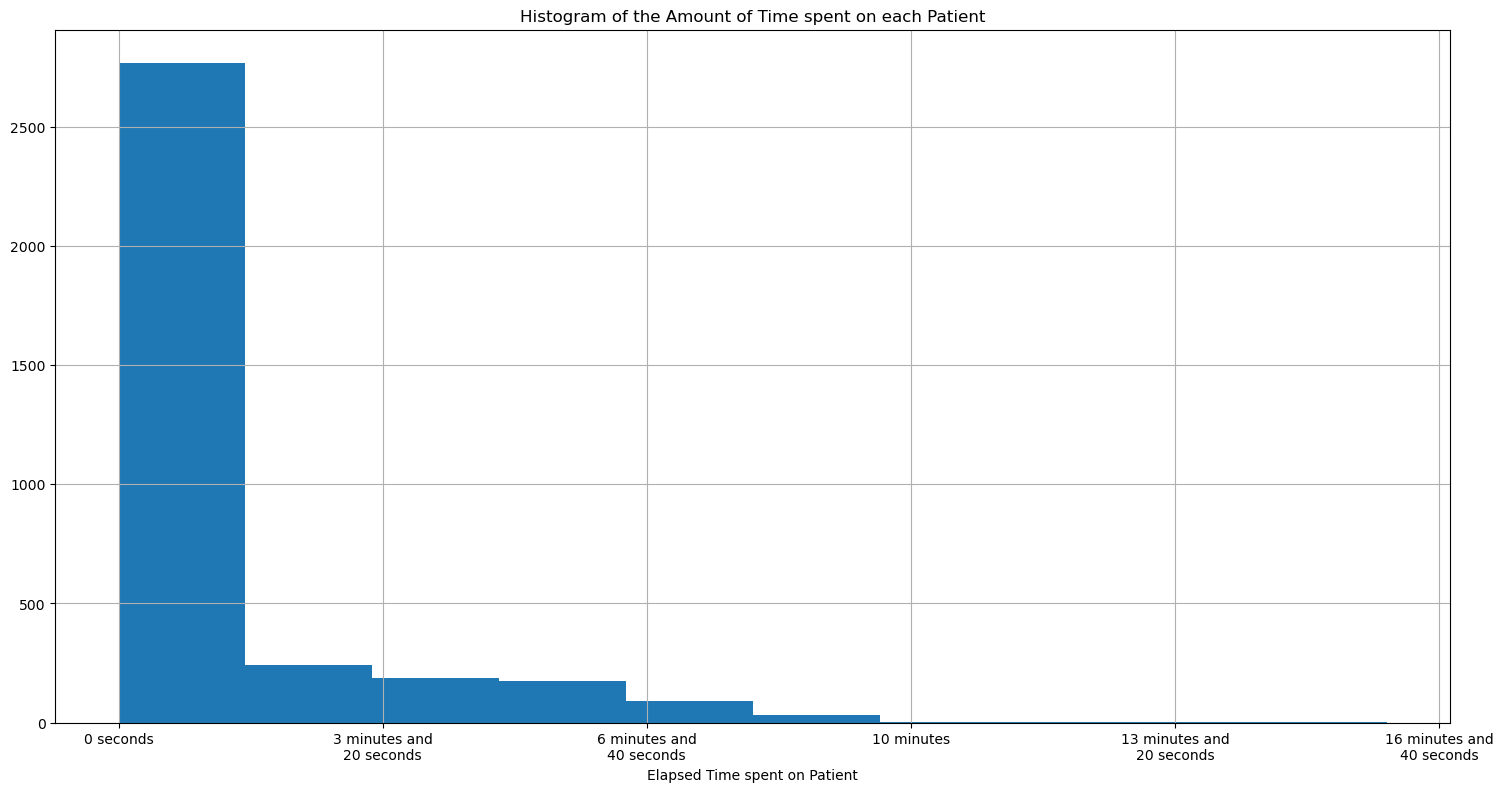

In [5]:

# Get a Histogram of the Amount of Time spent on each Patient
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
engagement_delta_df.engagement_delta.hist(ax=ax)

# Set the title and labels
ax.set_title('Histogram of the Amount of Time spent on each Patient')
ax.set_xlabel('Elapsed Time spent on Patient')

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[0])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list);

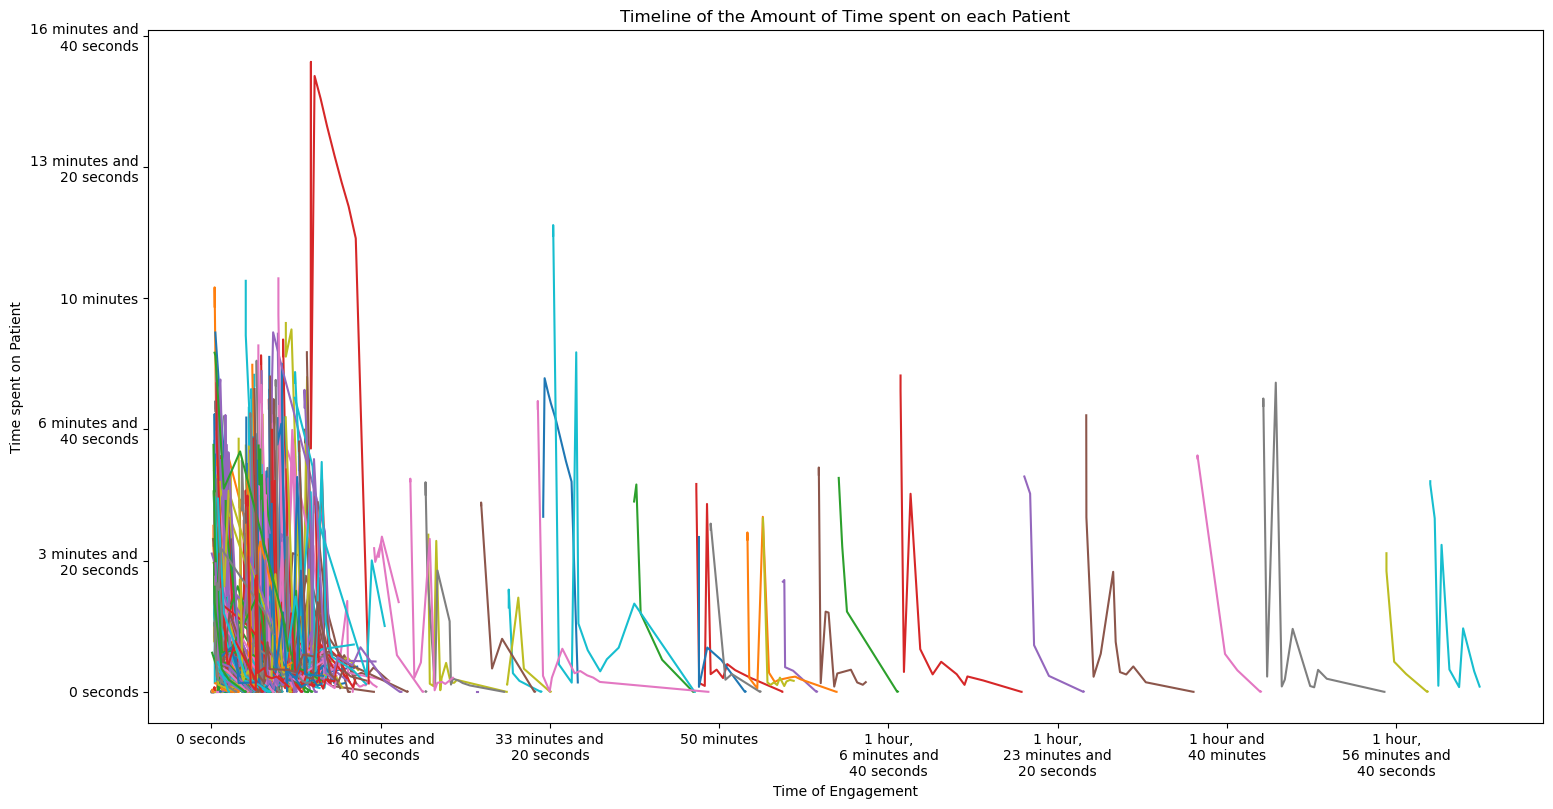

In [6]:

# Add all time groups as line plots of engagement start vs delta
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
for (session_uuid, time_group), df in engagement_delta_df.groupby(['session_uuid', 'time_group']):
    df.sort_values('engagement_start').plot(x='engagement_start', y='engagement_delta', kind='line', ax=ax, label=None)

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[0])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list)

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Set the title and labels
ax.set_title('Timeline of the Amount of Time spent on each Patient')
ax.set_xlabel('Time of Engagement')
ax.set_ylabel('Time spent on Patient')
legend = plt.legend(loc=None)
legend.set_visible(False);

In [7]:

# Get the time group with the most patients
columns_list = ['session_uuid', 'time_group']
patients_srs = frvrs_logs_df.groupby(columns_list).patient_id.unique().map(lambda x: len(x))
values_tuple = patients_srs.sort_values().tail(1).index.item()
{c: v for c, v in zip(columns_list, values_tuple)}

{'session_uuid': '5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0', 'time_group': 1}

In [8]:

# Get the most patients in one time group
srs = patients_srs.value_counts().sort_index()
mask_series = (srs > 1)
max_ranking = srs[mask_series].tail(1).index.tolist()[0]
print(f'{max_ranking} patients are being seen in one session')

26 patients are being seen in one session


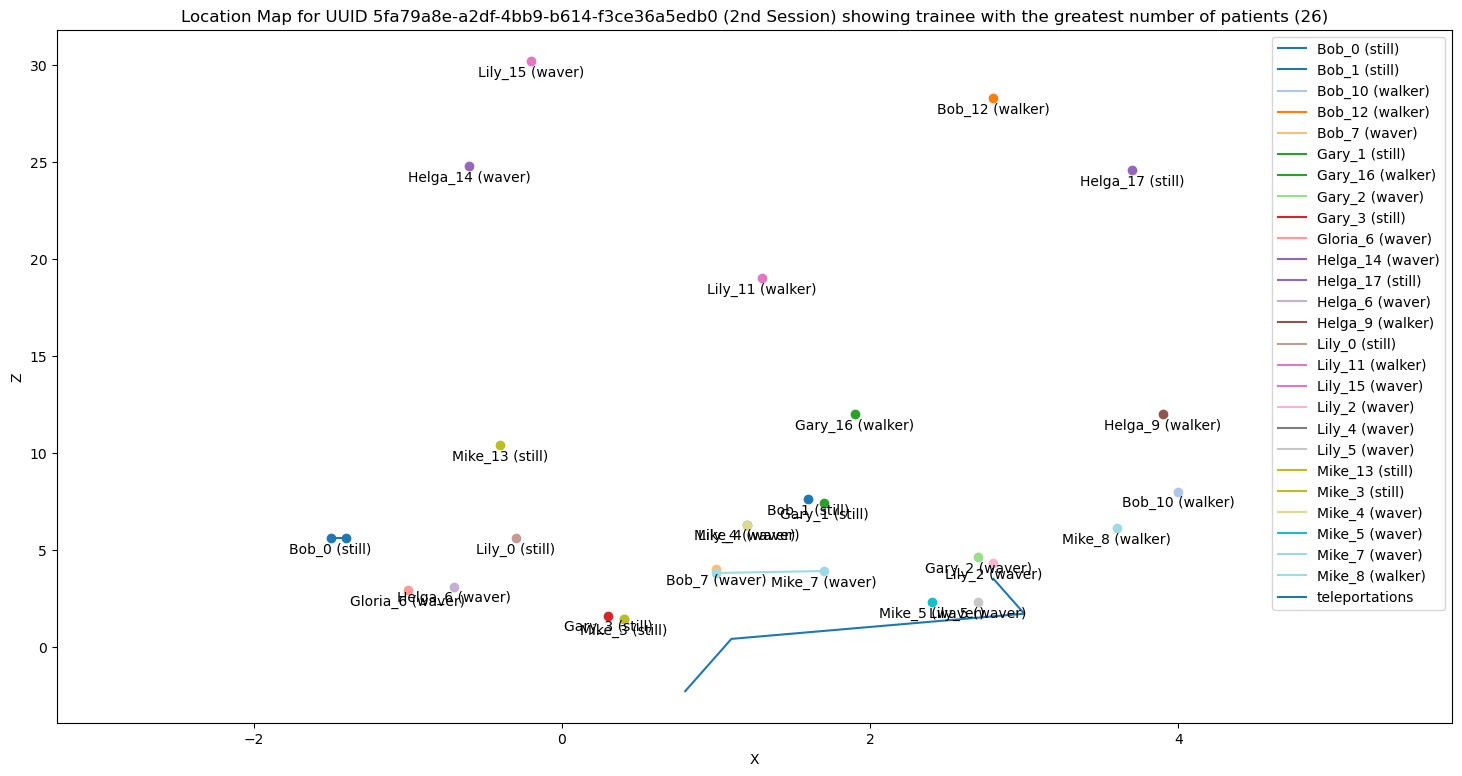

In [9]:

# Visualize the patients in a map
session_uuid = values_tuple[0]
time_group = values_tuple[1]
base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.time_group == time_group)

title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(time_group+1)} Session)'
title += ' showing trainee with the greatest number of patients ('
title += humanize.intword(max_ranking) + ')'
nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

In [10]:

# Group the engagement delta patients by session and rank order them
columns_list = ['patient_ranking', 'engagement_start', 'engagement_delta']
patient_ranking_df = DataFrame([], columns=columns_list)
for (session_uuid, time_group), df in engagement_delta_df.groupby(['session_uuid', 'time_group']):
    offset = df.engagement_start.min()
    df.engagement_start = df.engagement_start - offset
    # df.engagement_stop = df.engagement_stop - offset
    columns_list = ['index', 'engagement_start', 'engagement_delta']
    df = df.drop_duplicates(
        subset=['engagement_start', 'engagement_delta']
    ).sort_values('engagement_start').reset_index(drop=True).reset_index(drop=False)[columns_list].rename(
        columns={'index': 'patient_ranking'}
    )#.iloc[:max_ranking]
    # group_max_ranking = df.patient_ranking.max()
    # if group_max_ranking > (max_ranking + 1): raise
    patient_ranking_df = pd.concat([patient_ranking_df, df], axis='index')

In [11]:

patient_ranking_df

,patient_ranking,engagement_start,engagement_delta
0,0,0.0,0.0
1,1,652.0,0.0
2,2,1314.0,0.0
0,0,0.0,148143.0
1,1,1.0,119913.0
...,...,...,...
6,6,99878.0,36517.0
7,7,111957.0,24438.0
8,8,144236.0,20559.0
9,9,171342.0,23394.0


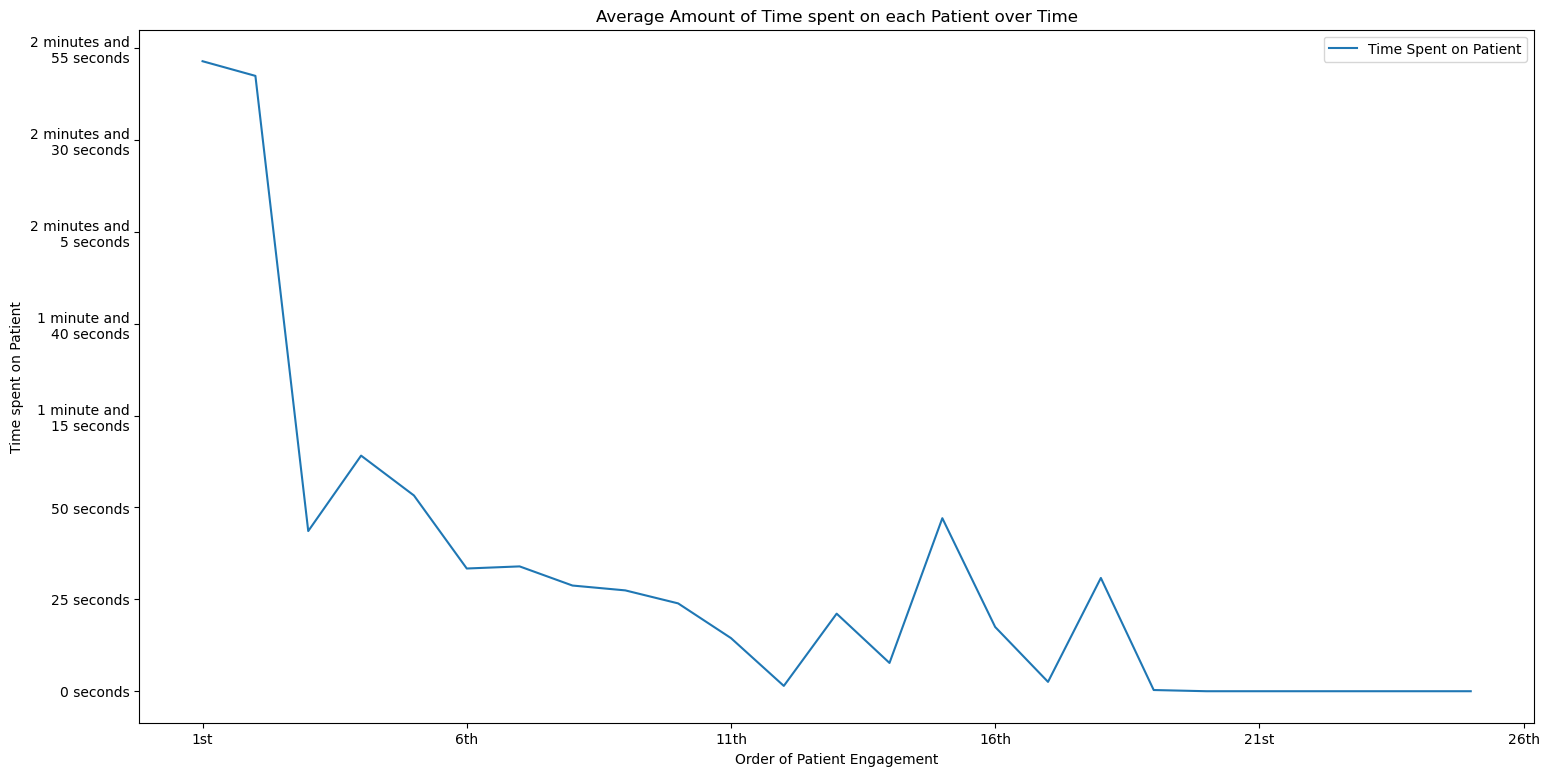

In [12]:

ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
patient_ranking_df.dropna(axis='index', how='any').groupby('patient_ranking').mean().reset_index(drop=False).plot(
    x='patient_ranking', y='engagement_delta', kind='line', label='Time Spent on Patient', ax=ax
)
ax.set_title('Average Amount of Time spent on each Patient over Time')
ax.set_xlabel('Order of Patient Engagement')
ax.set_ylabel('Time spent on Patient')

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.ordinal(int(text_obj.get_position()[0])+1)
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list);

In [13]:

print(engagement_delta_df.columns.tolist())
engagement_delta_df.sample(5).dropna(axis='columns', how='all').T

['session_uuid', 'time_group', 'patient_id', 'engagement_start', 'engagement_stop', 'engagement_delta', 'delta00', 'delta01', 'delta02', 'delta03', 'delta04', 'delta05', 'delta06', 'delta07', 'delta08', 'delta09', 'delta10']


,2244,2199,295,1739,255
session_uuid,9fac5a9d-0f55-4473-9744-f7100561354f,992d4672-7993-44ba-890c-0d8605ccefdd,14a344df-eee2-4fd1-b182-e3cdacd9026c,7de52180-d823-4f9e-9003-aeab8139970b,0b891add-e0c3-463d-948d-7f491f1d10ef
time_group,1,2,2,2,4
patient_id,Mike_0 Root,Gloria_8 Root,Bob_0 Root,Gloria_8 Root,Lily_15 Root
engagement_start,48195.0,279900.0,389884.0,257641.0,817539.0
engagement_stop,249540,655409,395865,426749,817539
engagement_delta,201345.0,375509.0,5981.0,169108.0,0.0
delta00,187741.0,320765.0,0.0,155956.0,NaN
delta01,NaN,39327.0,NaN,NaN,NaN
delta02,NaN,15417.0,NaN,NaN,NaN


In [14]:

columns_list = [f'delta{i:02d}' for i in range(11)]
df = engagement_delta_df.groupby('patient_id').mean()[columns_list]#.sample(4)
# mask_series = df.index.isin(['Gary_1 Root', 'Gloria_8 Root', 'Helga_10 Root', 'Mike_0 Root', 'Mike_2 Root'])
mask_series = ~df.delta07.isnull()
df = df[mask_series].sort_values('delta00', ascending=False)
display(df)

,delta00,delta01,delta02,delta03,delta04,delta05,delta06,delta07,delta08,delta09,delta10
patient_id,,,,,,,,,,,
Helga_10 Root,318485.839286,89231.500000,20212.000000,16970.666667,3968.5,5467.00,3751.000000,6730.0,NaN,NaN,NaN
Mike_2 Root,147733.881356,66237.181818,28508.647059,16650.300000,2454.0,6333.00,17682.333333,11279.5,4579.0,6600.0,4628.0
Mike_0 Root,135143.923077,110333.100000,30230.111111,18298.300000,16827.5,3253.25,2236.333333,10774.0,17647.0,6552.0,3164.0
Mike_7 Root,375.215517,132313.666667,39755.666667,10176.500000,7165.0,6672.00,7534.000000,22852.0,NaN,NaN,NaN


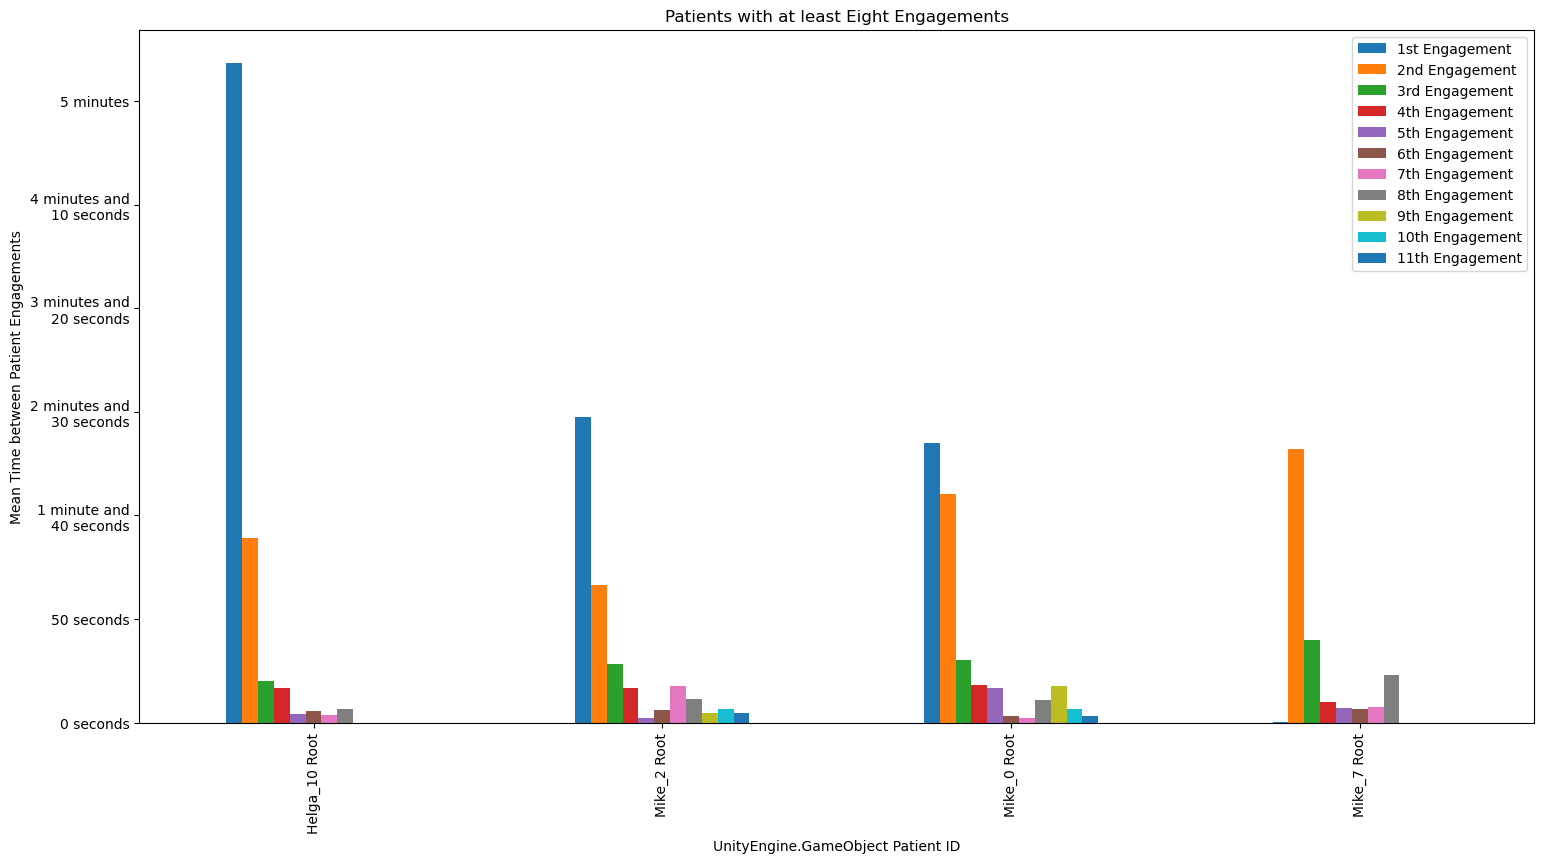

In [15]:

ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
df.plot(kind='bar', ax=ax)
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Set the legend text objects
legend_texts = plt.legend().get_texts()
for i in range(11):
    legend_texts[i].set_text(f'{humanize.ordinal(i+1)} Engagement')
ax.set_title('Patients with at least Eight Engagements')
ax.set_xlabel('UnityEngine.GameObject Patient ID')
ax.set_ylabel('Mean Time between Patient Engagements');